# Double-Sided Crystal Ball Signal Fit
This notebook fits the double-sided crystal ball function to the Monte-Carlo simulated signal events. Only pure category 10 and category 50 events are used as these are the 'best' quality signal events. The fit routines will be a least-squares (technically a chi-square as we will include errors) and a maximum likelihood fit.

In [1]:
# Gather the necessary libraries needed
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
import uproot as up

NBINS = 100

ModuleNotFoundError: No module named 'hepstats'

In [2]:
sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
with up.open(sname + ":DTT1520me/DecayTree") as f:
    df = f.arrays(['Lb_M', 'Lb_BKGCAT'], library='pd')
    df = df.sample(frac=1, random_state=0)
    df = df[~df.index.duplicated(keep='first')]

In [3]:
df['cat'] = np.where(df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# Create a category column which is based on the BKGCAT value 1 = signal, 0 = non-signal
df.drop('Lb_BKGCAT', axis=1, inplace=True)
# Now remove the BKGCAT column, it is redundant now
df = df[df['cat'] == 1]

In [4]:
df.drop(['cat'], inplace=True, axis=1)
df.head()

,Lb_M
57429,5562.917939
90819,5609.557202
102912,5634.664143
72651,5544.834894
67569,5248.033155


## Plotting Initial Mass Distribution
Now we will plot the initial mass distribution for the events we care about, that is signal category 1 events. This is just so we know what we are working with. Errors are computed assuming Poisson statistics that is $\sigma\propto\sqrt{N}$.

In [6]:
low_mass_limit, high_mass_limit = 4500, 6500
data = df[df['Lb_M'].between(low_mass_limit, high_mass_limit)]
# Trim the data to within these regions

In [17]:
h, bins = np.histogram(data['Lb_M'], bins=NBINS)
# Manual approach (use bayesian blocks?)

In [52]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

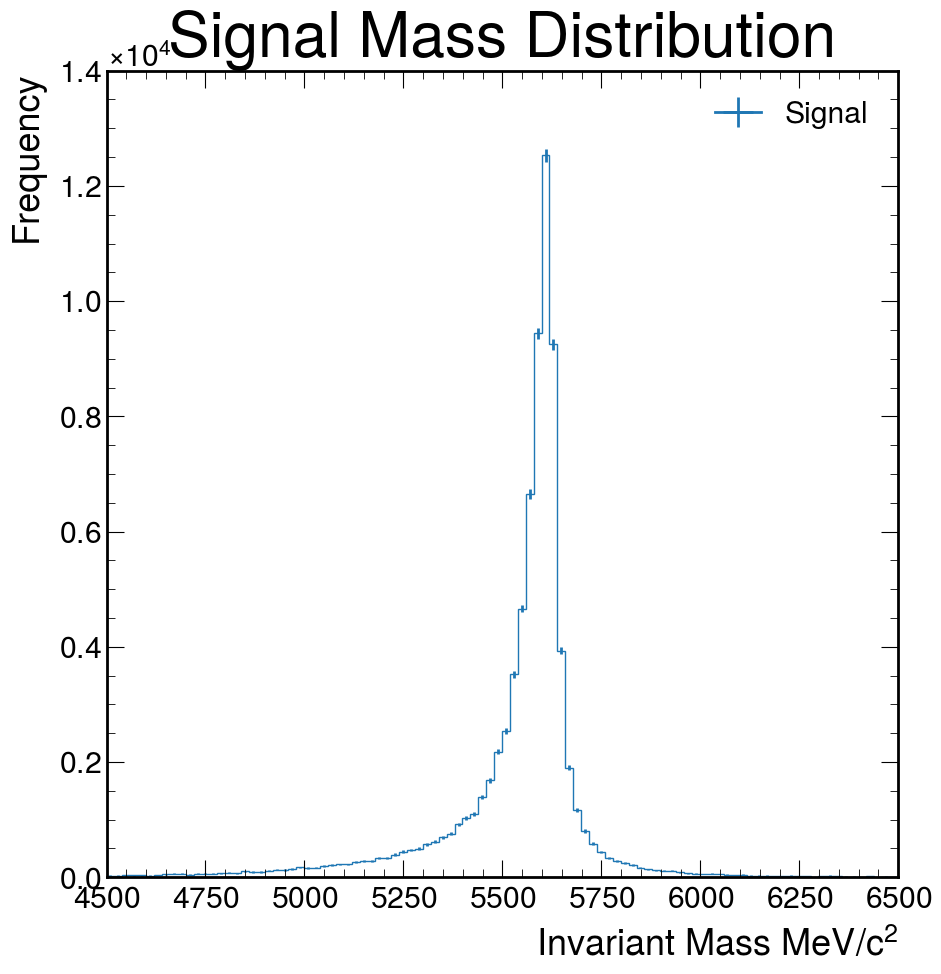

In [54]:
fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Signal')
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass MeV$/c^2$')
plt.legend()
plt.tight_layout()
plt.title('Signal Mass Distribution')
plt.savefig('../images/signalfits/Mass_Distribution_Signal.png', dpi=800)
plt.show()

## Preparation for Fitting the DSCB
Now we have plotted these data we will now attempt to fit them using a statistically sound routine(s). Before fitting we need to remove all the bins with zero frequency and hence zero error to prevent issues when doing math.

Secondly the DSCB is a probabilty distribution as such we should normalise the values associated with the previously computed histogram.

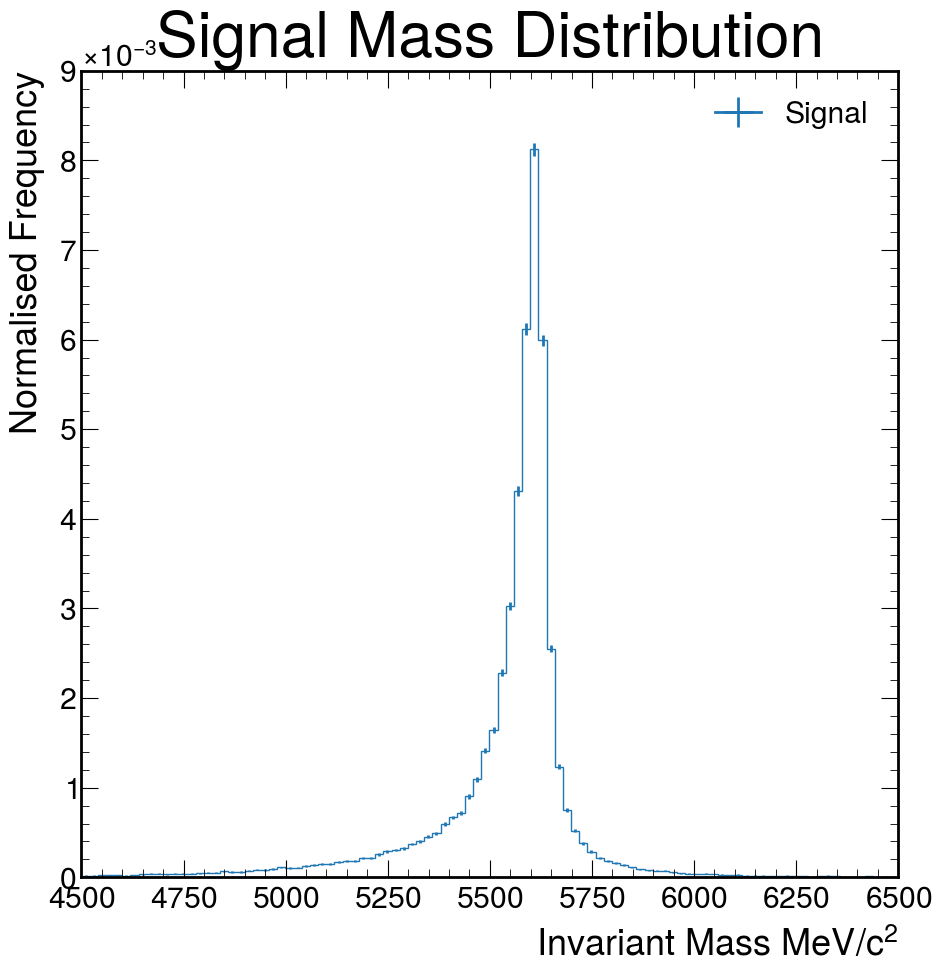

In [55]:
hnorm, binsnorm = np.histogram(data['Lb_M'], bins=NBINS, density=True)
scale_factor = max(h)/max(hnorm)

fig, ax = plt.subplots(1, 1)
hep.histplot(hnorm, binsnorm, yerr=np.sqrt(h)/scale_factor, ax=ax, label='Signal')
plt.ylabel('Normalised Frequency')
plt.xlabel(r'Invariant Mass MeV$/c^2$')
plt.legend()
plt.tight_layout()
plt.title('Signal Mass Distribution')
plt.savefig('../images/signalfits/Mass_Distribution_Signal_Normalised.png', dpi=800)
plt.show()

## Defining and Fitting
Now we have scaled our data and errors down appropriately with some, unseen but calculated, scale factor. We now need to define the DSCB function and try to fit it!

In [28]:
def dscb(x, mu, sigma, alow, ahigh, nlow, nhigh):
    # See https://arxiv.org/pdf/2011.07560.pdf
    import numpy as np
    z = (x - mu)/sigma
    values = []
    
    # Apply a specific function to the shifted values based on initial values
    for v in z:
        fx = 0
        if v < -alow:
            fx = np.exp(-0.5 * (alow**2)) * (((alow/nlow) * (nlow/alow - alow - v))**(-nlow))
        elif v > ahigh:
            fx = np.exp(-0.5 * (ahigh**2)) * (((ahigh/nhigh) * (nhigh/ahigh - ahigh + v))**(-nhigh))
        else:
            fx = np.exp(-0.5 * (v**2))
        values.append(fx)
    values = np.array(values)
    x_gaps = np.array([x[i+1] - x[i] for i in range(0, len(x)-1)])
    # The widths of each 'bin' that the function is being evaluated over
    mean_values = np.array([np.mean([values[i], values[i+1]]) for i in range(len(values)-1)])
    
    N = 1/np.sum(np.multiply(x_gaps, mean_values))
    #print(f'Scaling factor: {N}\nNormalised: {np.sum(N*values)}')
    return N * values# Works but needs some serious optimisation
    

In [29]:
from scipy.optimize import curve_fit

bin_centres = np.array([np.mean(binsnorm[i:i+2]) for i in range(len(binsnorm)-1)])

d_norm = np.array([bin_centres, hnorm, np.sqrt(h)/scale_factor]).T
# Make an array of the bin centroid the frequency and the associated error (normalised)

d_norm = d_norm[d_norm[:,1]!=0,:]
# Remove all the bins with no signal candidates recorded to prevent fitting issues

popt, pcov = curve_fit(dscb, d_norm[:,0], d_norm[:,1], p0=[5600, 40, 0.7, 1.43, 5.01, 5.13], sigma=d_norm[:,2])

/tmp/ipykernel_3183449/1331268361.py:11: RuntimeWarning: invalid value encountered in double_scalars
  fx = np.exp(-0.5 * (alow**2)) * (((alow/nlow) * (nlow/alow - alow - v))**(-nlow))
/tmp/ipykernel_3183449/1331268361.py:13: RuntimeWarning: invalid value encountered in double_scalars
  fx = np.exp(-0.5 * (ahigh**2)) * (((ahigh/nhigh) * (nhigh/ahigh - ahigh + v))**(-nhigh))


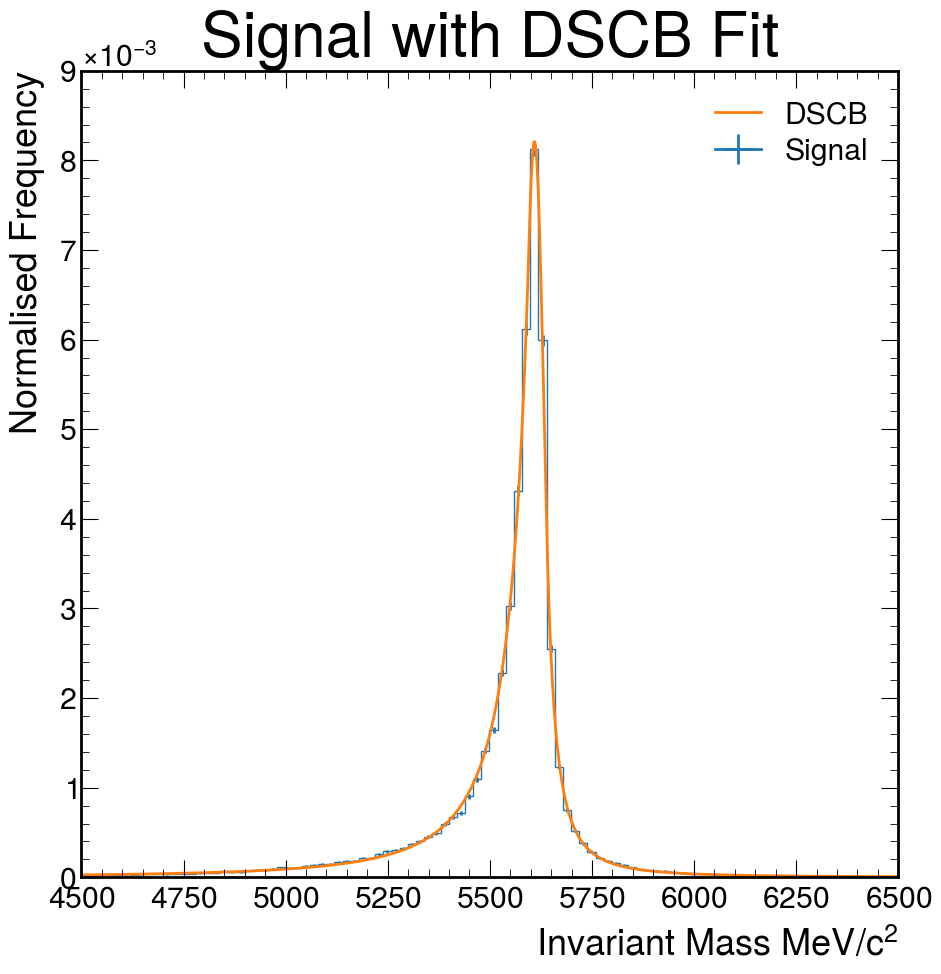

In [57]:
masses = np.linspace(4500, 6500, 1000)

fig, ax = plt.subplots(1, 1)
hep.histplot(hnorm, binsnorm, yerr=np.sqrt(h)/scale_factor, ax=ax, label='Signal')
ax.plot(masses, dscb(masses, *popt), label='DSCB', linewidth=2)
plt.ylabel('Normalised Frequency')
plt.xlabel(r'Invariant Mass MeV$/c^2$')
plt.legend()
plt.tight_layout()
plt.title('Signal with DSCB Fit')
plt.savefig('../images/signalfits/Mass_Distribution_Signal_Normalised.png', dpi=800)
plt.show()

Great news! We have a fit using a least-squares routines with errors on the parameters. Now let us calculate a chi-square per d.o.f on this fit.

In [32]:
# Re-scale the data back up to normal frequencey range
y_pred = dscb(masses, *popt)
scaled_y_pred = y_pred * scale_factor

In [39]:
from scipy.stats import chi2

y_pred2 = dscb([np.mean(bins[i:i+2]) for i in range(len(bins)-1)], *popt)*scale_factor

chi = np.sum(((h-y_pred2)/h)**2)
chi, chi2.ppf(0.05, df=len(y_pred2)-6)

(10.286370430797387, 72.63976778588469)

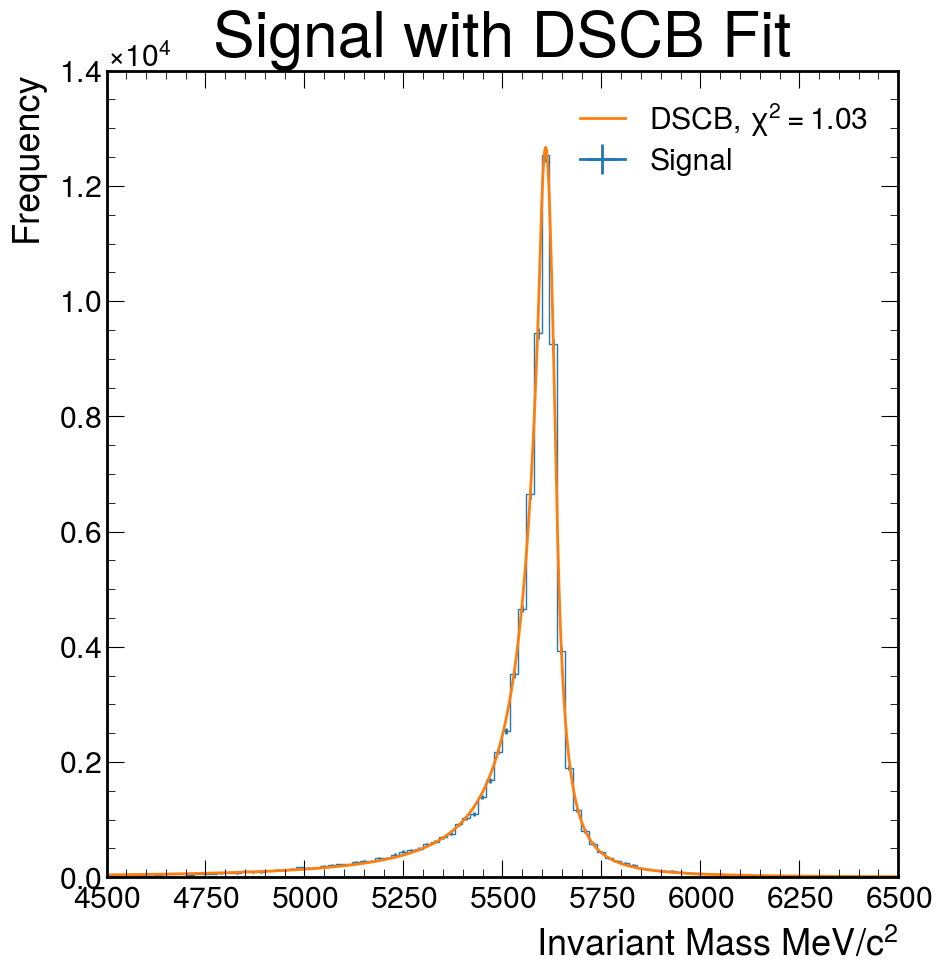

In [58]:
fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Signal')
ax.plot(masses, dscb(masses, *popt)*scale_factor, label=r'DSCB, $\chi^2=1.03$', linewidth=2)
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass MeV$/c^2$')
plt.legend()
plt.tight_layout()
plt.title('Signal with DSCB Fit')
plt.savefig('../images/signalfits/Mass_Distribution_Signal_Fit.png', dpi=800)
plt.show()

In [44]:
e = np.sqrt(np.diag(pcov))
for j, i in enumerate(popt):
    print(f'Value: {i:.3f} +/- {e[j]:.3f}')

Value: 5609.199 +/- 0.602
Value: 24.549 +/- 0.942
Value: 0.538 +/- 0.023
Value: 1.200 +/- 0.044
Value: 2.291 +/- 0.051
Value: 2.079 +/- 0.064


In [45]:
f = open('DSCB_Fit_Parameters.txt', 'w')
for j, i in enumerate(popt):
    writeable = f'{i} +/- {e[j]}\n'
    f.write(writeable)
f.close()